In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.fftpack import idct

Variable initialization

In [2]:
M = 32 # signal dimension
N = 2 * M # number of atoms in the expansion

C = np.zeros((M, M)) # matrix containing the standard basis (a kronecker delta in each column)
DCT = np.zeros((M, M)) #matrix containing the DCT basis (a DCT function in each column)

Generate the 1D-DCT basis

In [3]:
for i in range(M):
    a = np.zeros(M)
    a[i] = 1
    temp = np.reshape(idct(a),-1)
    norm = np.linalg.norm(temp)
    DCT[:, i] = temp/norm


Generating the 1-D standard basis

In [4]:
for i in range(M):
    a = np.zeros(M)
    a[i]=1
    C[:, i] = a


Define the dictionary $D = [DCT, C]$

Text(0.5, 1.0, 'Our dictionary M = 32, N = 64')

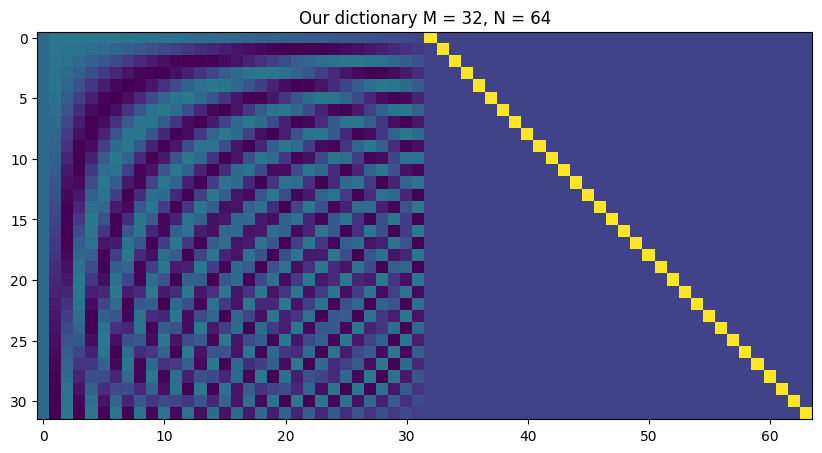

In [5]:
D = np.hstack((DCT, C)) # A = np.concatenate((C, D), axis=1)

plt.figure(figsize=(10,10))
plt.imshow(D)
plt.title(f'Our dictionary M = {M}, N = {N}')

Generate a signal that is sparse w.r.t. $[D, C]$
-----------------------------------------
To this purpose add a spike to the sum of few DCT atoms, i.e., add a spike to s that is sparse w.r.t. D. Bear in mind that the spike is to be considered a signal to be reconstructed, rather than noise

In [6]:
L = 5
sigma_noise = 0.2

Randomly define the coefficients of a sparse representation w.r.t. $D$ (make sure the nonzero coefficients are sufficiently large)

In [7]:
x0 = np.zeros(N)
positions = np.random.choice(M, L, replace=False)
x0[positions] = np.random.rand(L)
x0

array([0.        , 0.        , 0.54635332, 0.43407318, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.10166852, 0.31724056, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.96818964,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])



Choose spike location and update x0

In [8]:
# choose random position from M to N (N = 2M)
spikeLocation = np.random.choice(M) + M # from 32 to 64
print(spikeLocation)
#add spike to x0
x0[spikeLocation] = 4*np.abs(max(x0)) # this is to make the spike at least 4 times bigger than the biggest magnitude on signal
x0

43


array([0.        , 0.        , 0.54635332, 0.43407318, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.10166852, 0.31724056, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.96818964,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 3.87275855, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

Synthetize the corresponding signal in the signal domain and add noise


In [9]:
# s0 = Dx
s0 = D @ x0 # noise free

# add noise
sigma = 10/255
sigma_noise = sigma * (np.random.normal(size=s0.shape))

# s = s0 + eta
s = s0 + sigma_noise

In [10]:
s0

array([ 0.40713596, -0.07649151,  0.36574337,  0.15841437,  0.06508239,
        0.18777926, -0.2501417 ,  0.13855849,  0.00615788, -0.46187126,
        0.05214594,  3.68086077, -0.30722782, -0.05571314, -0.37145471,
        0.01751153, -0.06817246, -0.3731496 ,  0.22609288, -0.05325042,
       -0.13071348,  0.23037952, -0.10061829,  0.18826644,  0.10941782,
       -0.15374984,  0.35229537, -0.04109077, -0.09655577,  0.28647698,
       -0.14528526,  0.08592559])

Plot the sparse signal

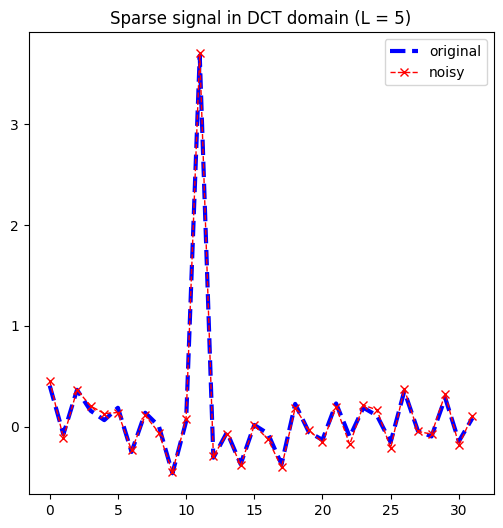

In [11]:
LN_WDT = 2
MRK_SZ = 10

plt.figure(figsize=(6, 6))
plt.plot(s0, 'b--', linewidth=LN_WDT+1)
plt.plot(s, 'r--x', linewidth=LN_WDT-1)
plt.title(f'Sparse signal in DCT domain (L = {L:.0f})')
plt.legend(['original', 'noisy'])


Matching Pursuit
----------------

Initialize all the variables, including the residual, namely the components of the signals that can not be represented (here the signal at the very beginning)

In [18]:
x_MP = np.zeros(N)

r = s - (D @ x_MP)
print(r)
print(r.shape)
l = 1 # cont

#initialize the norm of the resiudal (components not represented by the coefficients)

resNorm = np.linalg.norm(r)

MINIMUM_RES_NORM = 0.1

[ 0.45557868 -0.11165598  0.36505035  0.2050295   0.13072106  0.14061557
 -0.23503493  0.11171646 -0.05863741 -0.45106632  0.08116135  3.70304088
 -0.29218871 -0.06790171 -0.38377612  0.01289267 -0.12302818 -0.4041085
  0.189076   -0.03332796 -0.15531122  0.19492271 -0.17561203  0.21344532
  0.16704188 -0.21177888  0.37608143 -0.04585539 -0.07422699  0.32524486
 -0.18330728  0.10998724]
(32,)


MP loop starts.

Stoppint criteria: continue until the sparsity of the representation reaches L or as long as resNorm(l) is above a minimum value or as long as a maxium number of iterations have been reached

In [19]:
while np.count_nonzero(x_MP) < L and resNorm > MINIMUM_RES_NORM and l < 2*L:
    print(f"Cycle:{l}")

    # SWEEP STEP: look for the column of D that matches at best noisySignal
    # compute the residual w.r.t. each column of D
    e = np.zeros(N)
    for j in range(N):
        dj = D[:,j]
        zj = (r.T @ dj) / np.linalg.norm(dj) # dot product between 2 vectors = escalar
        e[j] = np.linalg.norm(r)**2 - zj**2 
        # this corresponds to solving e(j) = min( || dj zj - s ||),
        # which is obtained by setting zj = dj' r / || dj ||^2 (analytically defined)
        # there is no need to divide by || dj ||^2 since columns are nomalized

    # find the column of D that matches at best r, i.e. jStar = argmin(e(j))
    jStar = np.argmin(e) # index where the minimum value of e is located

    # find zjStar and djStar
    djStar = D[:,jStar]
    zjStar = (r.T @ djStar) / np.linalg.norm(djStar) # same as zj but not squared
    
    # UPDATE the jStar coefficient by *summing* the new component dj' r^(i) / || dj ||^2
    x_MP[jStar] = x_MP[jStar] + zjStar

    # remove the signal we have so far represented in coeff_MP (update the residual)
    r = s - (D @ x_MP)
    # r = r - (zjStar*djStar) - s # component that cannot be captured by the signal (the signal at the very beginning)

    l = l + 1

    # update the residual norm
    resNorm = np.linalg.norm(r)
    print()

Cycle:1

Cycle:2

Cycle:3

Cycle:4

Cycle:5



SYNTHESIS: reconstruct the signal, by inverting the transformation to reconstruct the signal

In [20]:
s_hat_MP = np.dot(D,x_MP)
s_hat_MP

array([ 3.92705170e-01, -7.79530970e-02,  3.75207308e-01,  1.50702963e-01,
        5.25742869e-02,  1.99803793e-01, -2.28738228e-01,  1.45830224e-01,
        4.37238478e-04, -4.47742842e-01,  8.76461314e-02,  3.51493596e+00,
       -3.25455609e-01, -4.43693717e-02, -3.49500137e-01,  4.25699580e-03,
       -1.06650616e-01, -3.81323873e-01,  2.39865059e-01, -8.69067264e-02,
       -1.83903273e-01,  2.27361218e-01, -8.90047597e-02,  1.58352049e-01,
        7.00284498e-02, -1.38994359e-01,  3.89669046e-01, -5.52140623e-02,
       -1.12988588e-01,  3.33777194e-01, -9.57030816e-02,  8.43364116e-02])

Those part of the signal that have not been modeled by s_hat (i.e. the projection on the subspace of the L most involved coefficients) corresponds to the norm of the residual

In [21]:
resNorm_MP = np.linalg.norm(r)


Show the result

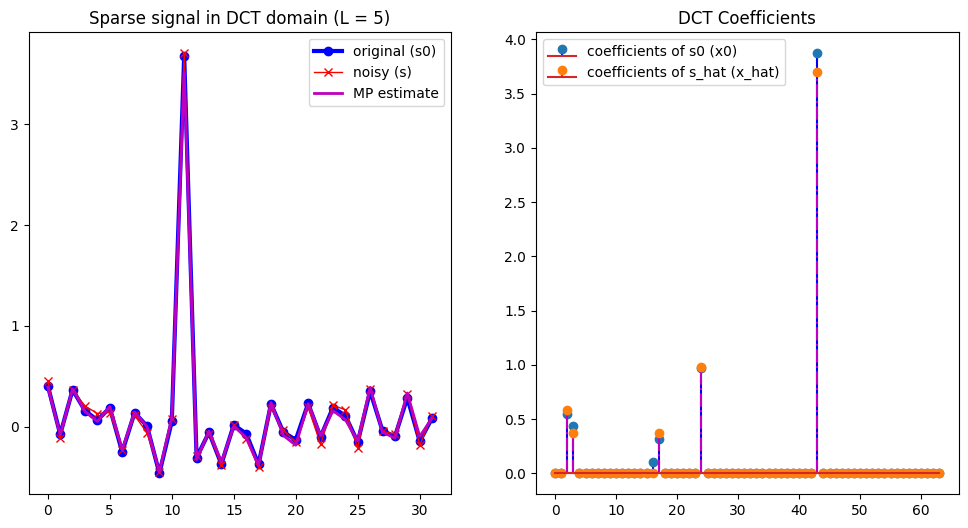

In [22]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(s0, 'b-o', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_MP, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal in DCT domain (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_MP, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('DCT Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x_hat)'])

